# Setup and Imports

In [1]:
import sys
if '../Toolkit' not in sys.path: sys.path.append('../Toolkit')

%load_ext autoreload
%autoreload 1

%aimport tools
%aimport models

import tools as t
import models as m

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.display import clear_output

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 113
import matplotlib.pyplot as plt
import seaborn as sns

RS = 35577 # global random state seed
raw_data_path = 'data-raw'
processed_data_path = 'data-processed'

In [2]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

%aimport transformations

transformations loaded, version: 0.1


In [27]:
df_data = t.from_pkl(f'{processed_data_path}/data_clean_pt_gmClusters.data.pkl')
df_data.shape
df_data.columns
df_data.head(3)

(8708128, 14)

Index(['experiment_id', 'bearing_1_id', 'bearing_2_id', 'timestamp', 'a1_x',
       'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'rpm', 'w', 'status',
       'rpm_clusters'],
      dtype='object')

,experiment_id,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,w,status,rpm_clusters
6012,1,0,1,2.004000,-0.560106,0.244341,0.369884,0.663609,0.482786,0.653591,423.529412,0.382562,0,0
6013,1,0,1,2.004333,-0.848694,-0.134197,0.369884,1.041226,0.578898,0.653591,423.529412,0.102063,0,0
6014,1,0,1,2.004667,-0.271517,0.338975,0.081789,0.663609,0.578898,1.351112,423.529412,0.049370,0,0


In [28]:
df_data = df_data.loc[df_data['rpm_clusters'] == 1].drop(columns='rpm_clusters')
df_data.head()

,experiment_id,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,w,status
23994,1,0,1,7.998000,-0.271517,-0.228832,-3.663456,3.590142,-0.189997,-0.542160,1440.0,0.944011,0
23995,1,0,1,7.998333,-0.560106,-0.512735,-1.742818,2.929312,-0.286109,-0.043930,1440.0,0.481882,0
23996,1,0,1,7.998667,-1.810657,-0.985908,-0.494403,2.551695,0.002226,-0.143576,1440.0,0.543777,0
23997,1,0,1,7.999000,-3.061209,-0.512735,-0.878530,1.135631,-0.286109,0.753237,1440.0,0.609410,0
23998,1,0,1,7.999333,-4.696546,-0.985908,-1.934881,0.569205,0.290562,0.852882,1440.0,0.655243,0


In [29]:
df_data = df_data.groupby(['experiment_id']).tail(23000).groupby(['experiment_id']).head(20000)

# Feature Engineering

In [30]:
def q1(arr):
    return np.quantile(arr, 0.25)

def q3(arr):
    return np.quantile(arr, 0.75)

def iqr(arr):
    return q3(arr)-q1(arr)

def kurtosis(series):
    return series.kurtosis()

def skew(series):
    return series.skew()

In [31]:
def grp_bearing(df, b_id):
    df_b_grp = df[['experiment_id', f'bearing_{b_id}_id', f'a{b_id}_x', f'a{b_id}_y', f'a{b_id}_z', 'status']]\
        .groupby(['experiment_id', f'bearing_{b_id}_id', 'status'])\
        .agg([np.min, np.max, np.sum, np.median, np.mean, np.std, np.var, q1, q3, iqr, kurtosis, skew])

    df_b_grp.columns = ['__'.join(col).strip()[3:] for col in df_b_grp.columns]
    df_b_grp.reset_index(inplace = True)
    df_b_grp.rename({f'bearing_{b_id}_id': 'bearing_id'}, axis=1, inplace=True)
    return df_b_grp
    

In [32]:
df_b1 = grp_bearing(df_data, 1)
df_b1.shape
df_b1['status'] = 1

df_b2 = grp_bearing(df_data, 2)
df_b2.shape

(112, 39)

(112, 39)

In [33]:
df_b1['status'].value_counts()
df_b2['status'].value_counts()

1    112
Name: status, dtype: int64

0    100
1     12
Name: status, dtype: int64

In [34]:
df_train = pd.concat([
        df_b1.sample(88, random_state=RS), # I want my train data to be balanced for status
        df_b2
    ], axis=0, ignore_index=True)
df_train = df_train.sort_values(by='status').reset_index(drop=True)
df_train.shape
df_train['status'].value_counts()
df_train.columns

(200, 39)

0    100
1    100
Name: status, dtype: int64

Index(['experiment_id', 'bearing_id', 'status', 'x__amin', 'x__amax', 'x__sum',
       'x__median', 'x__mean', 'x__std', 'x__var', 'x__q1', 'x__q3', 'x__iqr',
       'x__kurtosis', 'x__skew', 'y__amin', 'y__amax', 'y__sum', 'y__median',
       'y__mean', 'y__std', 'y__var', 'y__q1', 'y__q3', 'y__iqr',
       'y__kurtosis', 'y__skew', 'z__amin', 'z__amax', 'z__sum', 'z__median',
       'z__mean', 'z__std', 'z__var', 'z__q1', 'z__q3', 'z__iqr',
       'z__kurtosis', 'z__skew'],
      dtype='object')

In [35]:
df_plt = df_train
cols = [col for col in df_plt.columns if not (col in ['experiment_id', 'bearing_id', 'status'])]

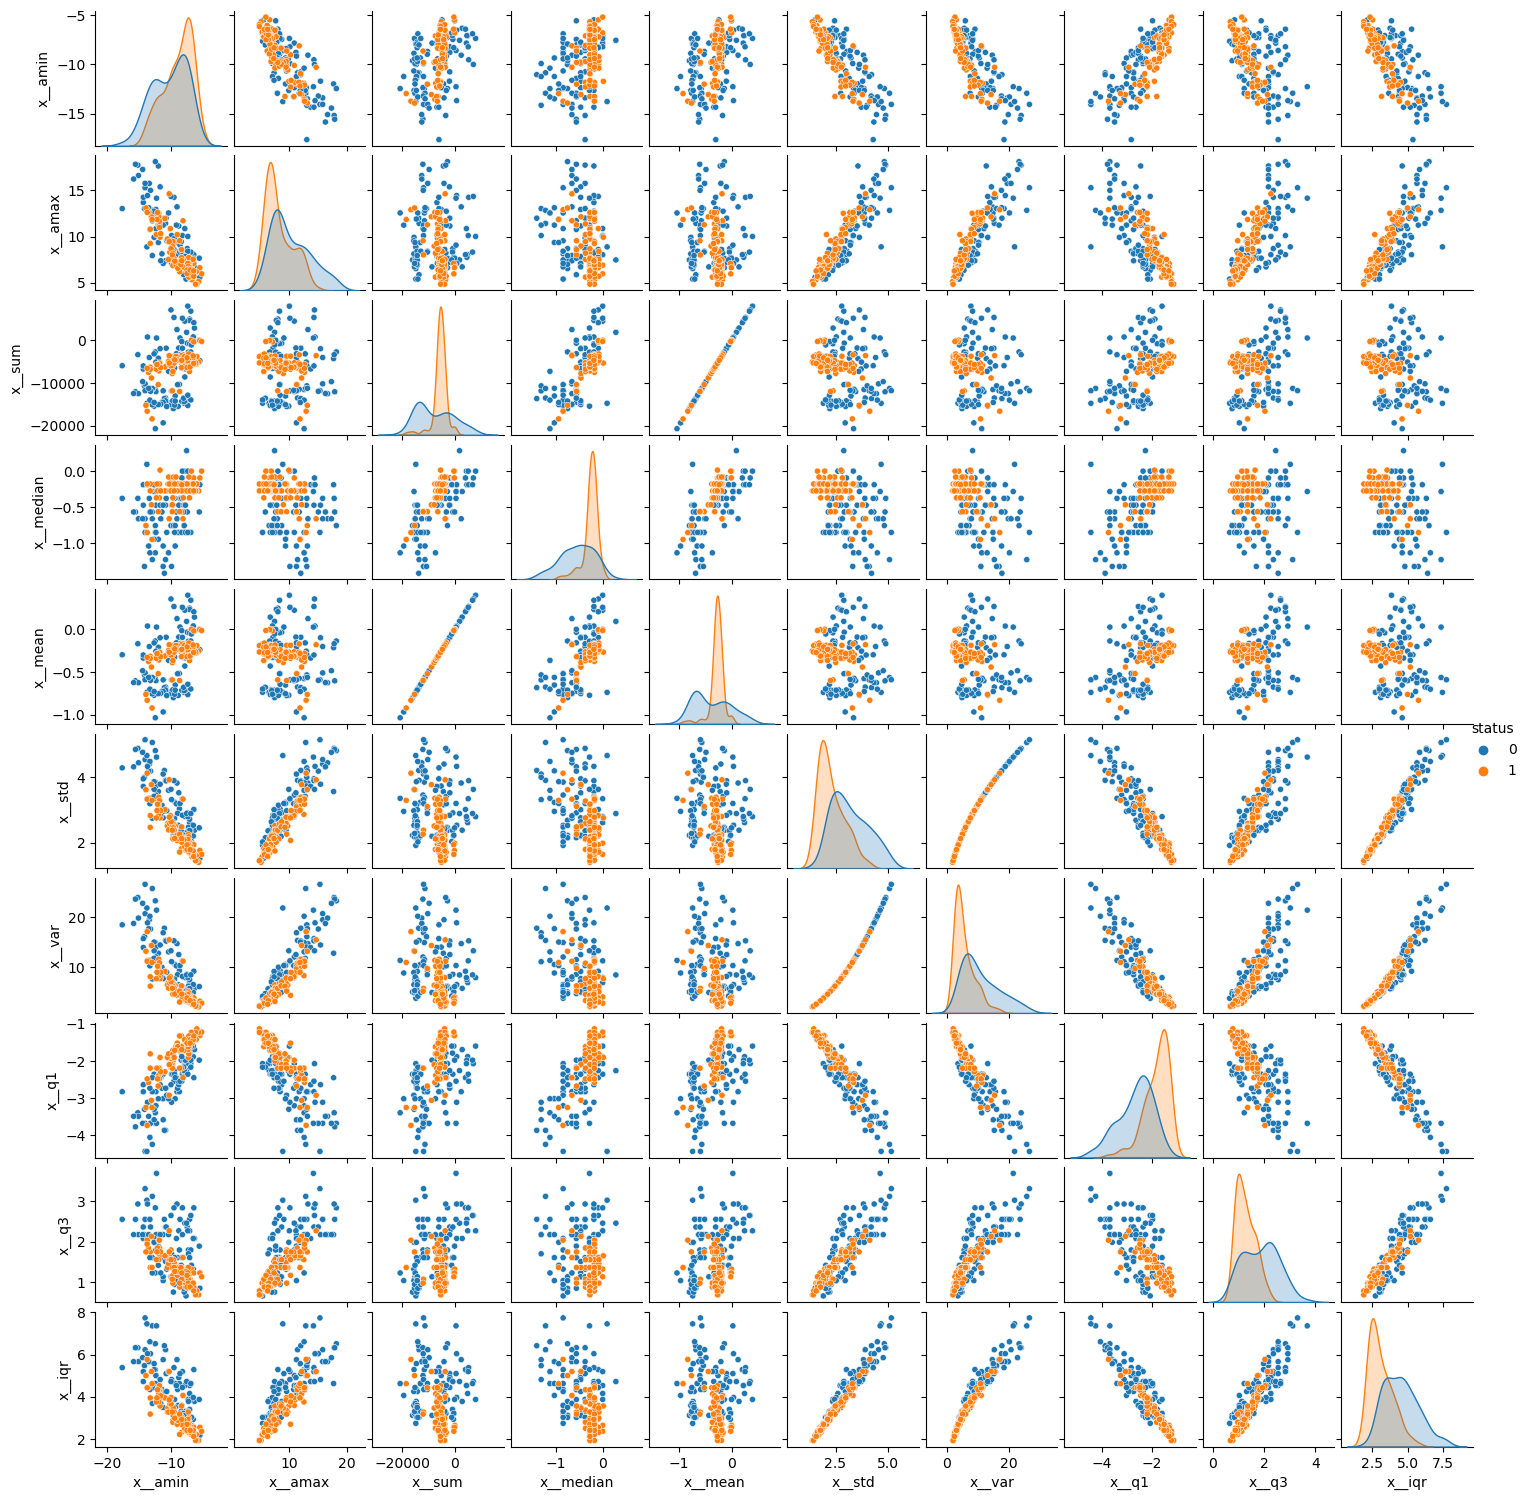

In [36]:
_ = sns.pairplot(data=df_plt, vars = cols[:10], hue='status', plot_kws={'s': 20}).fig.set_size_inches(15,15)

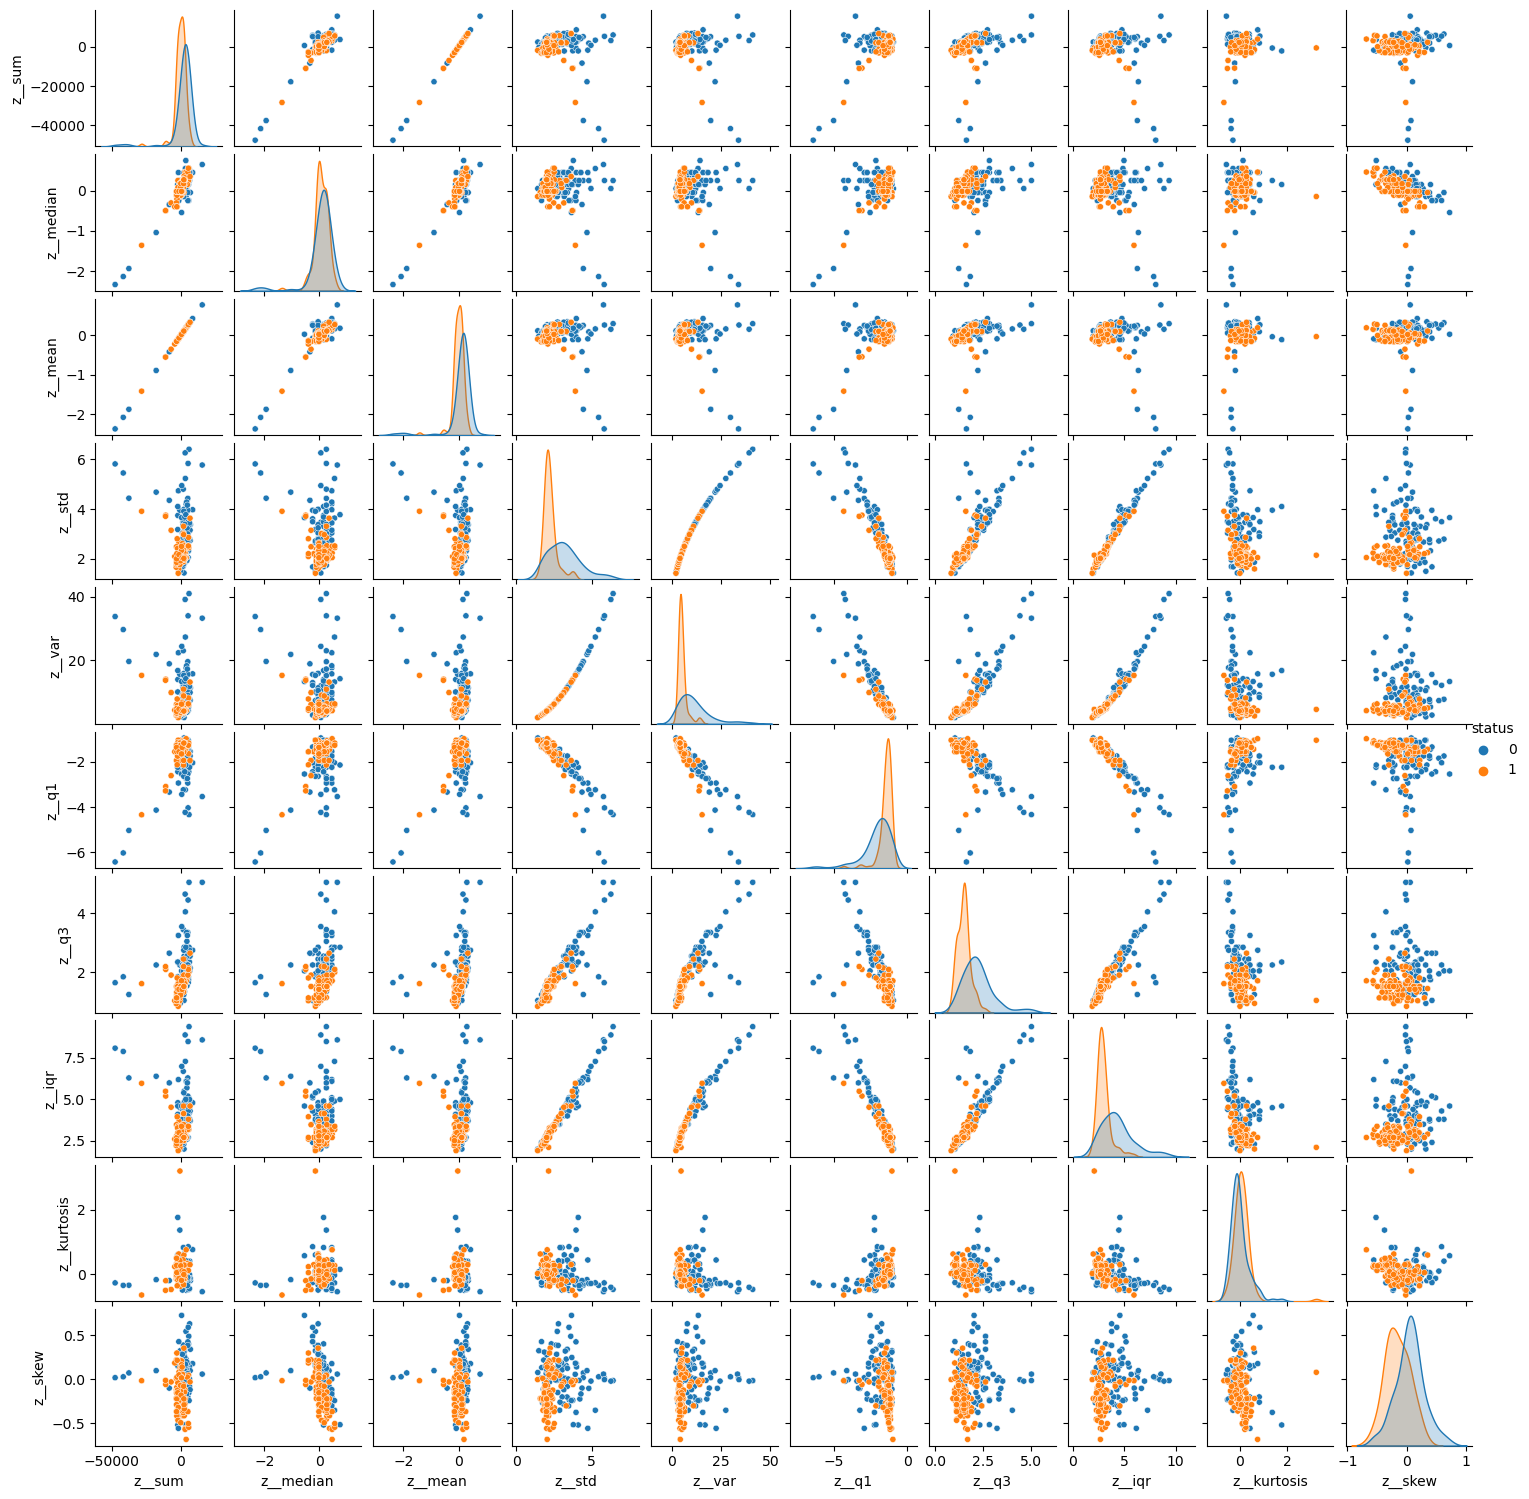

In [37]:
_ = sns.pairplot(data=df_plt, vars = cols[-10:], hue='status', plot_kws={'s': 20}).fig.set_size_inches(15,15)

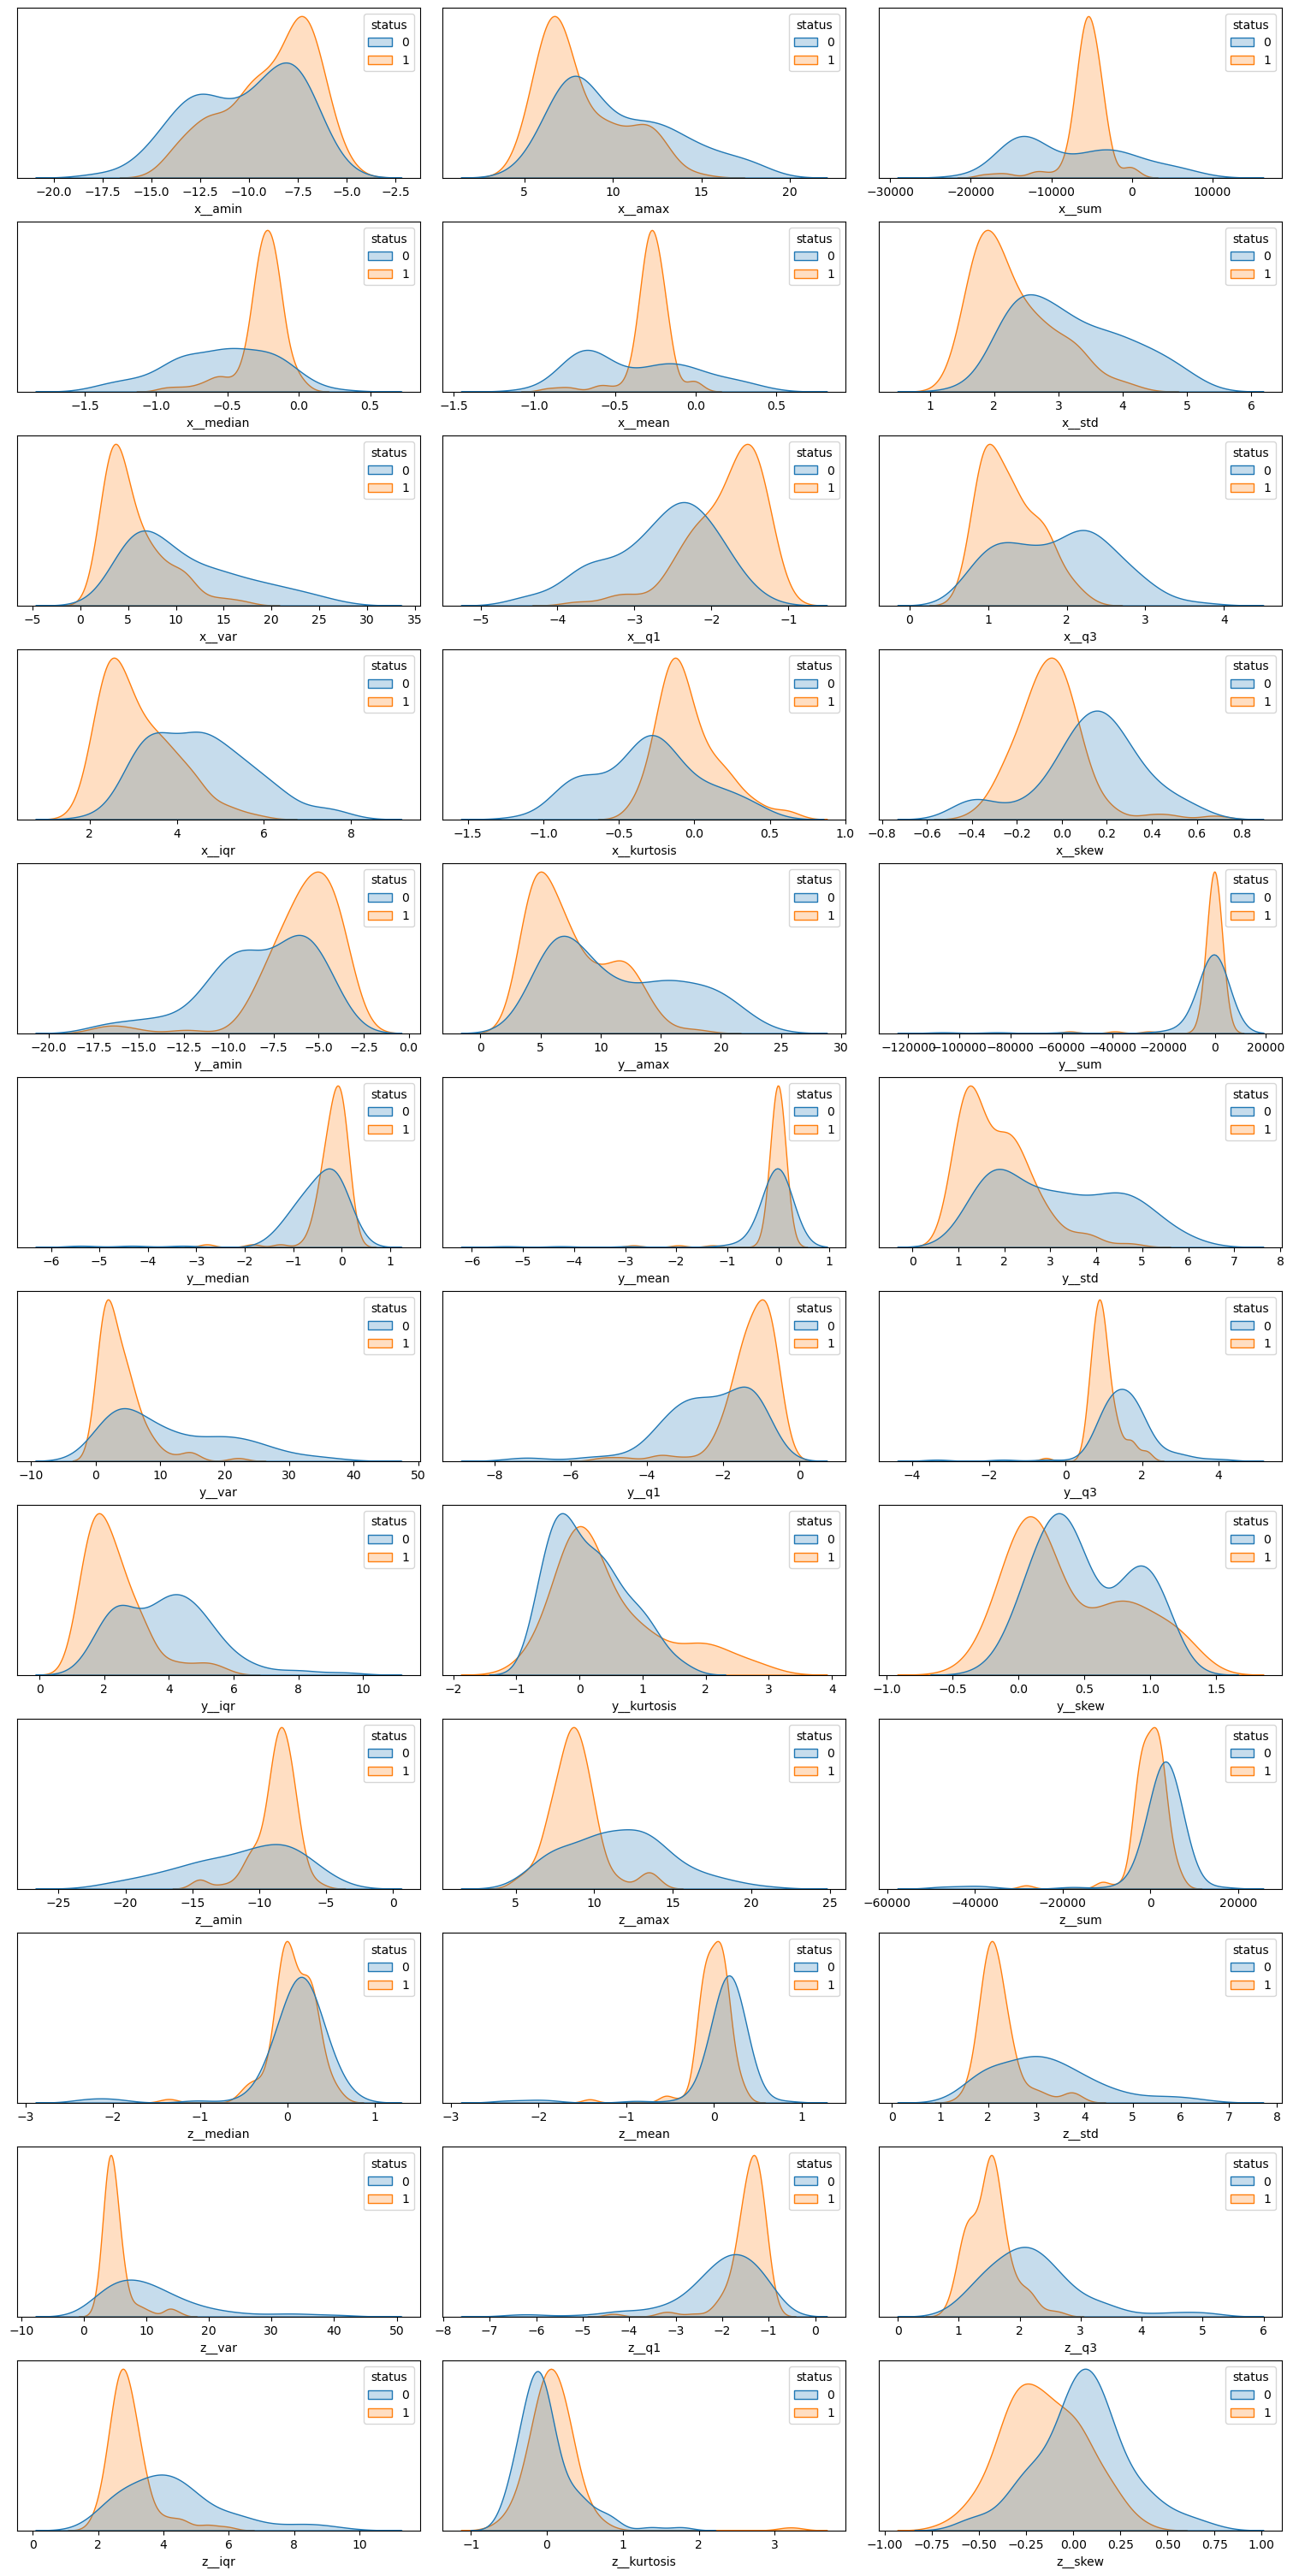

In [38]:
df_plt = df_train
# cols = ['x__amin', 'x__amax', 'x__sum','y__amin', 'y__amax', 'y__sum', 'z__amin', 'z__amax', 'z__sum']
cols = [col for col in df_plt.columns if not (col in ['experiment_id', 'bearing_id', 'status'])]

axs = t.get_axes(int(len(cols)/3), 3, 1/2)

for col, ax in zip(cols, axs.flat):
    _ = sns.kdeplot(ax=ax, data=df_plt, x=col, hue='status', shade=True)
    # _ = ax.axes.get_xaxis().set_visible(False)
    _ = ax.axes.get_yaxis().set_visible(False)
    # _ = ax.legend().set_visible(False)

In [39]:
df_train.columns
feature_cols = [col for col in df_plt.columns if not (col in ['experiment_id', 'bearing_id', 'status'])]

X = df_train[feature_cols]
X.shape
X.head(3)

y = df_train['status']
y.shape
y.head(3)

Index(['experiment_id', 'bearing_id', 'status', 'x__amin', 'x__amax', 'x__sum',
       'x__median', 'x__mean', 'x__std', 'x__var', 'x__q1', 'x__q3', 'x__iqr',
       'x__kurtosis', 'x__skew', 'y__amin', 'y__amax', 'y__sum', 'y__median',
       'y__mean', 'y__std', 'y__var', 'y__q1', 'y__q3', 'y__iqr',
       'y__kurtosis', 'y__skew', 'z__amin', 'z__amax', 'z__sum', 'z__median',
       'z__mean', 'z__std', 'z__var', 'z__q1', 'z__q3', 'z__iqr',
       'z__kurtosis', 'z__skew'],
      dtype='object')

(200, 36)

,x__amin,x__amax,x__sum,x__median,x__mean,x__std,x__var,x__q1,x__q3,x__iqr,x__kurtosis,x__skew,y__amin,y__amax,y__sum,y__median,y__mean,y__std,y__var,y__q1,y__q3,y__iqr,y__kurtosis,y__skew,z__amin,z__amax,z__sum,z__median,z__mean,z__std,z__var,z__q1,z__q3,z__iqr,z__kurtosis,z__skew
0,-9.060034,13.219381,2477.049596,-0.658051,0.123852,3.829330,14.663765,-2.829350,2.929312,5.758662,-0.426130,0.561011,-10.377857,17.782925,-563.189341,-1.343340,-0.028159,5.066817,25.672631,-3.073354,1.155569,4.228923,0.865318,1.146803,-11.303914,9.821011,2852.033876,0.354653,0.142602,2.868572,8.228708,-1.438973,2.048633,3.487606,0.158115,-0.351033
1,-11.986567,17.656383,-4324.591576,-0.186030,-0.216230,3.568302,12.732779,-2.451733,2.174078,4.625811,0.306838,-0.020774,-11.531200,20.281834,-949.078552,-0.574445,-0.047454,4.722609,22.303035,-2.881130,2.020576,4.901706,1.242337,0.811604,-10.805685,12.411804,3876.792055,-0.043930,0.193840,3.305365,10.925438,-2.236140,2.447216,4.683356,-0.264315,0.227793
2,-11.986567,11.236891,-4229.809657,-0.280434,-0.211490,3.161178,9.993044,-2.357329,1.890865,4.248194,-0.046345,0.069461,-9.993410,13.169554,-816.059706,-0.286109,-0.040803,2.984316,8.906140,-2.112235,2.020576,4.132811,0.025849,0.210335,-14.093999,11.415345,1590.317807,0.055715,0.079516,3.464984,12.006112,-2.236140,2.447216,4.683356,0.226098,-0.039530


(200,)

0    0
1    0
2    0
Name: status, dtype: int64

In [40]:
t.to_pkl((X, y), f'{processed_data_path}/all_b1_b2_cluster_20k_1.data.pkl', True)